In [1]:
import pandas as pd
from sklearn import tree
#import graphviz
import math
import matplotlib.pyplot as plt
import numpy as np

## Beolvasás és átalakítás

In [2]:
df = pd.read_csv('household_power_consumption.txt', sep=';', low_memory=False, na_values=['nan','?'], header=0,
                 dtype={'Date': str, 'Time': str, 'Global_active_power': float, 'Global_reactive_power': float,
                        'Voltage': float, 'Global_intensity': float,
                        'Sub_metering_1': float, 'Sub_metering_2': float, 'Sub_metering_3': float})
df = df.dropna()
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


#### Dátum külön szedése évre és hónap/nap-ra, értékek összegzése óránként

In [3]:
data = pd.DataFrame()
data['Year'] = df.apply(lambda row: row['Date'][-4:], axis = 1)
data['Date'] = df.apply(lambda row: row['Date'][:-5], axis = 1)
data['Hour'] = df.apply(lambda row: float(row['Time'][:2]), axis = 1)

data['Global_active_power'] = df['Global_active_power']
data['Global_reactive_power'] = df ['Global_reactive_power']
data['Voltage'] = df['Voltage']
data['Global_intensity'] = df['Global_intensity']
data['Sub_metering_1'] = df['Sub_metering_1']
data['Sub_metering_2'] = df['Sub_metering_2']
data['Sub_metering_3'] = df['Sub_metering_3']

data = data.groupby(['Year', 'Date', 'Hour']).sum().reset_index().drop(columns=['Year'])

In [4]:
data.shape

(34168, 9)

#### Oszlopok helyettesítése statisztikai adatokkal: 
adott hónap adott napján, adott órában az értékek minimuma, maximuma, szórása és átlaga

In [5]:
def calcGroupedBy(aggFunc):
    return data.groupby(['Date', 'Hour']).agg(aggFunc).reset_index().set_index(['Date', 'Hour'])

mins = calcGroupedBy('min')
maxs = calcGroupedBy('max')
means = calcGroupedBy('mean')
variances = calcGroupedBy('var')

In [7]:
stat_data = pd.DataFrame()

for i in range(3,9):
    col = data.columns[i]
    stat_data[col + '_min'] = mins[col]
    stat_data[col + '_max'] = maxs[col]
    stat_data[col + '_mean'] = means[col]
    stat_data[col + '_var'] = variances[col]
    
stat_data = stat_data.reset_index().dropna()

#### Évszak oszlop előállítása: 1-tél, 2-tavasz, 3-nyár, 4-ősz

In [10]:
def getSeason(date):
    month = int(date.split("/")[1])
    if 2 < month & month <= 5:
        return 2
    if 5 < month & month <= 8:
        return 3
    if 8 < month & month <= 11:
        return 4
    return 1

stat_data['Season'] = stat_data.apply(lambda row: getSeason(row['Date']), axis=1)
stat_data = stat_data.drop(columns=['Date'])

stat_data.head()

,Hour,Global_reactive_power_min,Global_reactive_power_max,Global_reactive_power_mean,Global_reactive_power_var,Voltage_min,Voltage_max,Voltage_mean,Voltage_var,Global_intensity_min,...,Sub_metering_1_var,Sub_metering_2_min,Sub_metering_2_max,Sub_metering_2_mean,Sub_metering_2_var,Sub_metering_3_min,Sub_metering_3_max,Sub_metering_3_mean,Sub_metering_3_var,Season
0,0.0,2.786,6.768,4.5720,3.009747,14478.00,14812.36,14566.3050,26949.830767,143.8,...,0.0,0.0,35.0,8.75,306.250000,0.0,1074.0,396.25,262180.250000,1
1,1.0,4.298,8.924,5.9310,4.183233,14449.83,14648.66,14515.3800,8282.862867,146.8,...,0.0,0.0,48.0,18.75,542.250000,0.0,1068.0,276.75,278594.250000,1
2,2.0,4.402,6.400,5.7260,0.819048,14564.73,14784.13,14645.4025,9541.956492,152.6,...,0.0,0.0,31.0,12.75,236.916667,0.0,1084.0,281.00,286937.333333,1
3,3.0,3.300,5.406,4.5185,0.782937,14514.79,14714.79,14617.3375,7057.561692,142.4,...,0.0,0.0,28.0,11.00,185.333333,0.0,1077.0,290.00,276806.000000,1
4,4.0,3.276,8.210,5.1110,5.028439,14463.91,14700.20,14552.6100,10852.092733,140.8,...,0.0,0.0,45.0,11.25,506.250000,0.0,1069.0,277.25,278963.583333,1


In [11]:
stat_data.shape

(8760, 26)

## Döntési fa

#### Tanító halmaz és teszthalmaz előállítása
3:1 arányban

In [12]:
train_size = math.floor(stat_data.shape[0] / 4 * 3)
test_size = stat_data.shape[0] - train_size
print("Train data size: " + str(train_size))
print("Test data size: " + str(test_size))

training = stat_data.head(train_size).reset_index(drop=True)
testing = stat_data.tail(test_size).reset_index(drop=True)

training_samples = training.drop(columns=['Season']).values
training_features = training['Season'].values

testing_samples = testing.drop(columns=['Season']).values
testing_features = testing['Season'].values

Train data size: 6570
Test data size: 2190


#### Döntési fa felépítése

In [13]:
clf = tree.DecisionTreeClassifier(max_depth=10, max_features=0.3, class_weight='balanced')
clf = clf.fit(training_samples, training_features)

#### Elkészült döntési fa ábrázolása

In [14]:
# dot_data = tree.export_graphviz(clf, out_file="myDecisionTree.dot")
# graph = graphviz.Source(dot_data)
# graph.render("myDecisionTree")

#### Eredmények kiértékelése
Kétdimenziós tömbben összegezzük, hányszor fordult elő, hogy egy adat esetén A évszak volt a megoldás, és a fa B évszakot döntött.

In [15]:
# expected:     wi,sp,su,au    predicted:
resultArray = [[0, 0, 0, 0],  # wi
               [0, 0, 0, 0],  # sp
               [0, 0, 0, 0],  # su
               [0, 0, 0, 0]]  # au

results = clf.predict(testing_samples)
for i in range(len(results)):
    origin = testing_features[i]
    predicted = results[i]
    oldValue = resultArray[predicted-1][origin-1]
    resultArray[predicted-1][origin-1] = oldValue + 1
    
first = resultArray[0]
second = resultArray[1]
resultArray[0] = resultArray[3]
resultArray[1] = resultArray[2]
resultArray[2] = second
resultArray[3] = first

resultArray

[[148, 200, 76, 265], [6, 48, 379, 103], [67, 188, 95, 107], [307, 116, 8, 77]]

#### Eredmény szemléltetése hődiagrammon

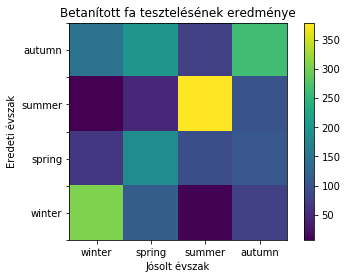

In [16]:
fig, ax = plt.subplots()
im = ax.imshow(resultArray)
fig.colorbar(im)
ax.set_xticklabels(['', 'winter', 'spring', 'summer', 'autumn'])
ax.set_yticklabels(['', 'autumn', '', 'summer', '', 'spring', '', 'winter'])
ax.set_xlabel('Jósolt évszak')
ax.set_ylabel('Eredeti évszak')
plt.title('Betanított fa tesztelésének eredménye')
plt.show()